In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy import stats
import math
pd.options.display.max_rows=200

In [2]:
df_ided_pred = pd.read_csv('/data/210827_SJH_prosit/massIVE-KB_predMS2.csv')
print(df_ided_pred.shape)

(109641264, 13)


In [3]:
df_ided_pred.head(174)

,RelativeIntensity,FragmentMz,ModifiedPeptide,LabeledPeptide,StrippedPeptide,PrecursorCharge,PrecursorMz,iRT,proteotypicity,FragmentNumber,FragmentType,FragmentCharge,FragmentLossType
0,0.035433,134.044780,_AAEAAGGKYRSTVSKSKD_,AAEAAGGKYRSTVSKSKD,AAEAAGGKYRSTVSKSKD,3,609.318273,-26.007053,-9.442945,1,y,1,noloss
1,0.000705,67.526030,_AAEAAGGKYRSTVSKSKD_,AAEAAGGKYRSTVSKSKD,AAEAAGGKYRSTVSKSKD,3,609.318273,-26.007053,-9.442945,1,y,2,noloss
2,0.000000,45.353110,_AAEAAGGKYRSTVSKSKD_,AAEAAGGKYRSTVSKSKD,AAEAAGGKYRSTVSKSKD,3,609.318273,-26.007053,-9.442945,1,y,3,noloss
3,0.000000,72.044390,_AAEAAGGKYRSTVSKSKD_,AAEAAGGKYRSTVSKSKD,AAEAAGGKYRSTVSKSKD,3,609.318273,-26.007053,-9.442945,1,b,1,noloss
4,0.000263,36.525833,_AAEAAGGKYRSTVSKSKD_,AAEAAGGKYRSTVSKSKD,AAEAAGGKYRSTVSKSKD,3,609.318273,-26.007053,-9.442945,1,b,2,noloss
5,0.000000,24.686314,_AAEAAGGKYRSTVSKSKD_,AAEAAGGKYRSTVSKSKD,AAEAAGGKYRSTVSKSKD,3,609.318273,-26.007053,-9.442945,1,b,3,noloss
6,0.143261,262.139740,_AAEAAGGKYRSTVSKSKD_,AAEAAGGKYRSTVSKSKD,AAEAAGGKYRSTVSKSKD,3,609.318273,-26.007053,-9.442945,2,y,1,noloss
7,0.000000,131.573520,_AAEAAGGKYRSTVSKSKD_,AAEAAGGKYRSTVSKSKD,AAEAAGGKYRSTVSKSKD,3,609.318273,-26.007053,-9.442945,2,y,2,noloss
8,0.000000,88.051430,_AAEAAGGKYRSTVSKSKD_,AAEAAGGKYRSTVSKSKD,AAEAAGGKYRSTVSKSKD,3,609.318273,-26.007053,-9.442945,2,y,3,noloss
9,0.635549,143.081500,_AAEAAGGKYRSTVSKSKD_,AAEAAGGKYRSTVSKSKD,AAEAAGGKYRSTVSKSKD,3,609.318273,-26.007053,-9.442945,2,b,1,noloss


In [137]:
df_ided = pd.read_csv('data/massIVE-KB/df_kb_strip.csv')
print(df_ided.shape)
df_ided.head(2)

(1457872, 6)


,CHARGE,PEPTIDE,PROTEINS,SPECTRAL_CNT,MZ,INTENSITY
0,3,KSTLASVNIQALPDKGQK,sp|Q9UNY4|TTF2_HUMAN,2,101.07149505615234;102.0557861328125;110.07170...,149737.359375;25633.95703125;215093.203125;678...
1,2,DEENTANSFLNYR,sp|Q12864|CAD17_HUMAN,8,102.05529022216797;120.08084869384766;129.0657...,19837.28515625;26364.921875;15893.0185546875;1...


# check peak quality

In [227]:
def pep2qual(pred_ms2, THRESHOLD=0.1):
    # make peptide to spectrum dictionary
    start = time.time()

    pep2ms2 = dict()
    for idx, (i, p, c, ft, fc) in enumerate(pred_ms2):
        if idx % 100000 == 0:
            print(idx, round(time.time() - start, 2), end='\r')

        if (p, c) not in pep2ms2:
            pep2ms2[(p, c)] = dict()
            for c_ in range(min(3, c)):
                pep2ms2[(p, c)]['y'+str(c_+1)]=[]
                pep2ms2[(p, c)]['b'+str(c_+1)]=[]
        pep2ms2[(p, c)][str(ft) + str(fc)].append(i)

    # check peak quality which means intensity >= 0.1
    pep2qualcnt = dict()
    pep2qualratio = dict()
    for k, v in pep2ms2.items():
        # peak count which above 0.1
        # v = (fragment_type, charge), intensity
        qualcnt = {ft_c:sum([1 for _ in li if _ >= THRESHOLD]) for ft_c, li in v.items()}
        # charge sum
        # chrage2, charge3 have few intensity >= 0.1
        qualcnt['total_y'] = sum([qualcnt[k] for k in qualcnt.keys() if k[0]=='y'])
        qualcnt['total_b'] = sum([qualcnt[k] for k in qualcnt.keys() if k[0]=='b'])
        qualcnt['total'] = max(qualcnt['total_y'], qualcnt['total_b'])

        l = len(v['y1'])  # same length y1, y2, y3, b1, b2, b3
        qualratio_y = sum([qualcnt[k] for k in qualcnt.keys() if k[0]=='y']) / (l*3)
        qualratio_b = sum([qualcnt[k] for k in qualcnt.keys() if k[0]=='b']) / (l*3)
        qualratio = round(max(qualratio_y, qualratio_b), 2)

        pep2qualcnt[k] = qualcnt['total']
        pep2qualratio[k] = qualratio
    return pep2qualcnt, pep2qualratio

* Ided Peptide

In [139]:
pred_ms2 = df_ided_pred[['RelativeIntensity', 'StrippedPeptide', 
                                    'PrecursorCharge',
                                    'FragmentType', 'FragmentCharge']].values

pep2qualcnt, pep2qualratio = pep2qual(pred_ms2)

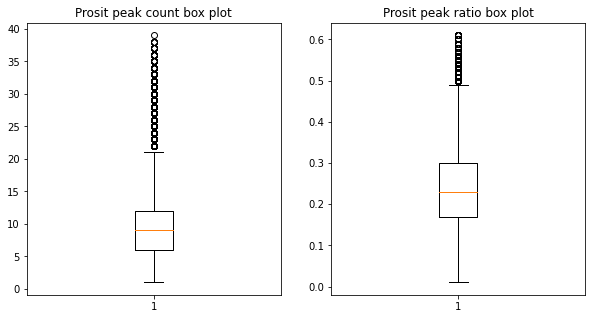

In [141]:
fig, ax = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(10,5)
ax[0].boxplot(pep2qualcnt.values())
# sns.violinplot(data=list(pep2qualcnt.values()))
ax[1].boxplot(pep2qualratio.values())


ax[0].set_title('Prosit peak count box plot')
ax[1].set_title('Prosit peak ratio box plot')

plt.show()

* Non Ided Peptide

In [201]:
df_pep_from_prot = pd.read_csv('data/uniprot/df_whole_pep_from_prot.csv')
df_nided_pep = df_pep_from_prot.loc[df_pep_from_prot.ID==0].PEP.unique()
df_nided_pred = pd.read_csv('/data/210827_SJH_prosit/uniprot_predMS2.csv')

In [205]:
tmp_for_merge = pd.DataFrame(df_nided_pep, columns=['StrippedPeptide'])
df_nided_pred = df_nided_pred.merge(tmp_for_merge, how='inner').reset_index(drop=True)

In [208]:
npred_ms2 = df_nided_pred[['RelativeIntensity', 'StrippedPeptide', 
                                    'PrecursorCharge',
                                    'FragmentType', 'FragmentCharge']].values

npep2qualcnt, npep2qualratio = pep2qual(npred_ms2)

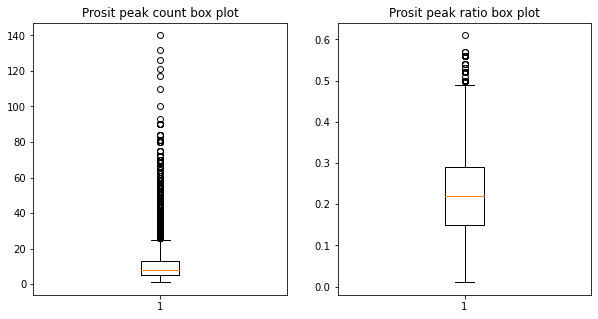

In [209]:
fig, ax = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(10,5)
ax[0].boxplot(npep2qualcnt.values())
ax[1].boxplot(npep2qualratio.values())


ax[0].set_title('Prosit peak count box plot')
ax[1].set_title('Prosit peak ratio box plot')

plt.show()

* see together

In [416]:
df_nonid = pd.DataFrame([[_, 'nonID', 'cnt'] for _ in npep2qualcnt.values()
                        if _ <= 40], columns=['peakCnt', 'label', 'cnt'])  # filtration as same as id
df_id = pd.DataFrame([[_, 'ID', 'cnt'] for _ in pep2qualcnt.values()], columns=['peakCnt', 'label', 'cnt'])
df_peakcnt = pd.concat([df_nonid, df_id], axis=0).reset_index(drop=True)

df_nonid = pd.DataFrame([[_, 'nonID', 'ratio'] for _ in npep2qualratio.values()], columns=['peakratio', 'label', 'ratio'])
df_id = pd.DataFrame([[_, 'ID', 'ratio'] for _ in pep2qualratio.values()], columns=['peakratio', 'label', 'ratio'])
df_peakratio = pd.concat([df_nonid, df_id], axis=0).reset_index(drop=True)

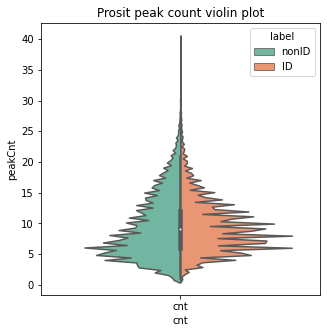

In [417]:
plt.figure(figsize=(5,5))
sns.violinplot(x='cnt', y="peakCnt", hue="label",
                    data=df_peakcnt, 
                    palette="Set2",
                    split=True,
                    scale="count"
                   )
plt.title('Prosit peak count violin plot')
plt.show()

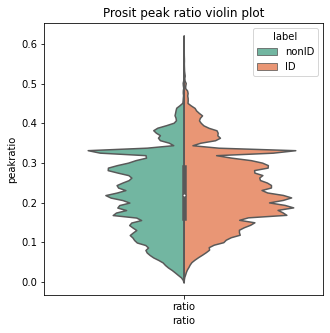

In [418]:
plt.figure(figsize=(5,5))
sns.violinplot(x='ratio', y="peakratio", hue="label",
                    data=df_peakratio, 
                    palette="Set2",
                    split=True,
                    scale="count"
                   )
plt.title('Prosit peak ratio violin plot')
plt.show()

* check other threshold

In [228]:
def qual_viz(t):
    pep2qualcnt, pep2qualratio = pep2qual(pred_ms2, THRESHOLD=t)
    npep2qualcnt, npep2qualratio = pep2qual(npred_ms2, THRESHOLD=t)
    df_nonid = pd.DataFrame([[_, 'ID', 'cnt'] for _ in npep2qualcnt.values()
                            if _ <= 40], columns=['peakCnt', 'label', 'cnt'])  # filtration as same as id
    df_id = pd.DataFrame([[_, 'nonID', 'cnt'] for _ in pep2qualcnt.values()], columns=['peakCnt', 'label', 'cnt'])
    df_peakcnt = pd.concat([df_nonid, df_id], axis=0).reset_index(drop=True)
    df_nonid = pd.DataFrame([[_, 'ID', 'ratio'] for _ in npep2qualratio.values()], columns=['peakratio', 'label', 'ratio'])
    df_id = pd.DataFrame([[_, 'nonID', 'ratio'] for _ in pep2qualratio.values()], columns=['peakratio', 'label', 'ratio'])
    df_peakratio = pd.concat([df_nonid, df_id], axis=0).reset_index(drop=True)

    plt.figure(figsize=(5,5))
    sns.violinplot(x='cnt', y="peakCnt", hue="label",
                        data=df_peakcnt, 
                        palette="Set2",
                        split=True,
                        scale="count"
                       )
    plt.title('Prosit peak count violin plot')
    plt.show()
    plt.figure(figsize=(5,5))
    sns.violinplot(x='ratio', y="peakratio", hue="label",
                        data=df_peakratio, 
                        palette="Set2",
                        split=True,
                        scale="count"
                       )
    plt.title('Prosit peak ratio violin plot')
    plt.show()

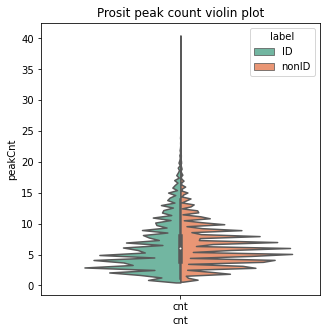

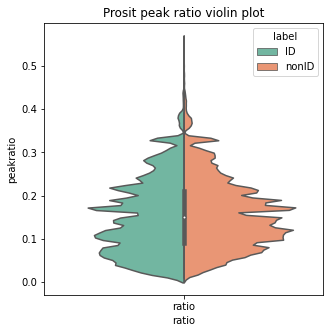

In [229]:
qual_viz(0.2)

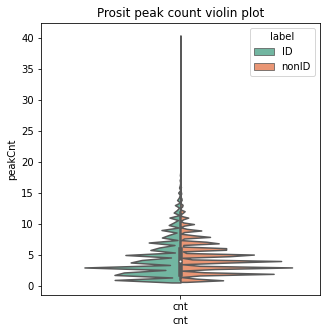

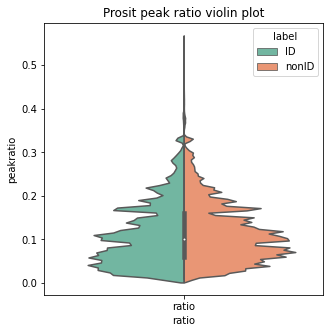

In [230]:
qual_viz(0.3)

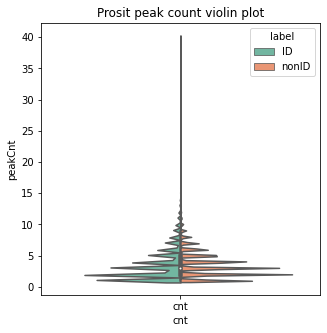

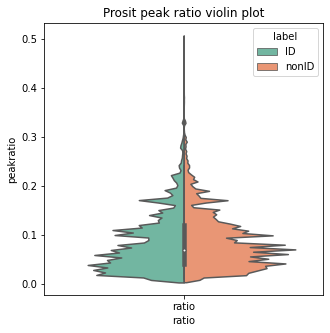

In [231]:
qual_viz(0.4)

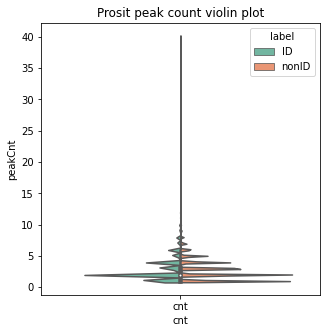

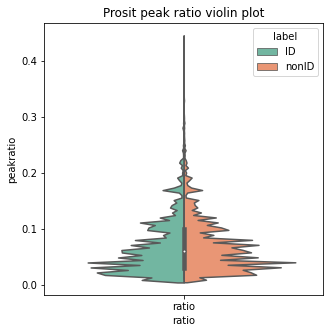

In [232]:
qual_viz(0.5)

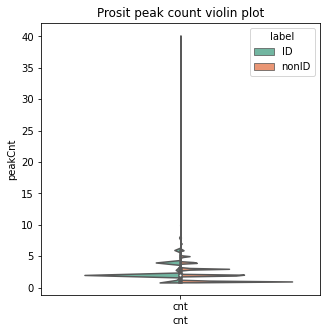

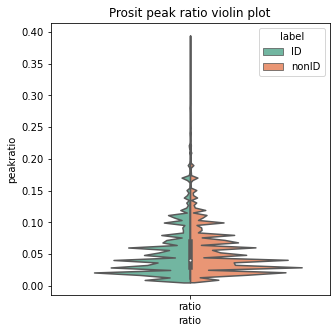

In [233]:
qual_viz(0.6)

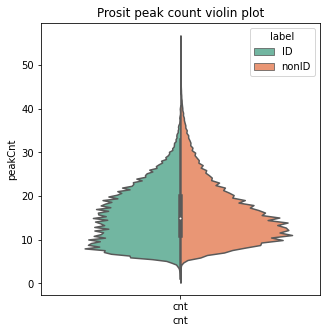

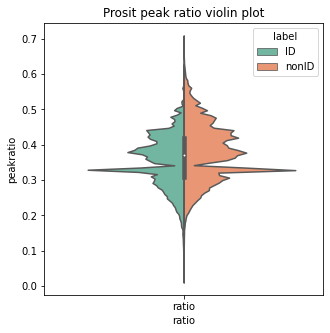

In [235]:
qual_viz(0.01)

# check prediction accuracy
  - is Prosit reliable ?

* pearson corr

In [142]:
def norm2(vec):
    return sum([_**2 for _ in vec])**0.5
def dotproduct(v1, v2):
    return sum(np.array(v1)*np.array(v2))
def vec2norm(vec):
    return np.array(vec) / (sum([_**2 for _ in vec])**0.5)
def vec2r_(v1, v2):
    return stats.pearsonr(v1, v2)
def vec2r(v1, v2):
    v1_mean = sum(v1)/len(v1)
    v2_mean = sum(v2)/len(v2)
    
    covdot = dotproduct(np.array(v1)-v1_mean, np.array(v2)-v2_mean)
    v1_std = sum([(_-v1_mean)**2 for _ in v1])**0.5
    v2_std = sum([(_-v2_mean)**2 for _ in v2])**0.5
    return round(covdot / (v1_std*v2_std), 2)

* spectrum angle

In [143]:
def inv_cos(scalar):
    return math.acos(scalar)

In [192]:
def vec2sa(v1, v2):
    # normalized spectral contrast angle
    v1 = vec2norm(v1)
    v2 = vec2norm(v2)
    # 1 : same vector v1,v2 (high corr) , 0 : low corr (angle theta = 90 degree)
    return round(1 - (2*inv_cos(dotproduct(v1, v2))) / math.pi, 2)

In [145]:
def get_spectrum_fromdf(sequence, charge, df_ided_pred=df_ided_pred, df_ided=df_ided):
    # making vector prediction
    check_pred = df_ided_pred.loc[(df_ided_pred.StrippedPeptide==sequence) & (df_ided_pred.PrecursorCharge==charge)]

    # scaling float to int (cause comparing with experimental spectrum)
    c_pred = dict()
    for k, v in zip(check_pred['FragmentMz'].values, check_pred['RelativeIntensity'].values):
        if int(k) not in c_pred:
            c_pred[int(k)]=[]
        c_pred[int(k)].append(v)
    for k, v in c_pred.items():
        c_pred[k] = max(v)

    # making vector experiment
    check_expe = df_ided.loc[(df_ided.PEPTIDE==sequence) & (df_ided.CHARGE==charge)]

    # initialize with prediction's m/z position
    c_expe = dict()
    for init_k in c_pred.keys():
        c_expe[init_k] = [0]

    # scaling float to int (cause comparing with prediction spectrum)
    for k, v in zip(list(map(float, check_expe['MZ'].values[0].split(';')))  ,
                    list(map(float, check_expe['INTENSITY'].values[0].split(';'))) ):
        if int(k) in c_pred.keys():
            c_expe[int(k)].append(v)
    for k, v in c_expe.items():
        c_expe[k] = max(v)

    # following paper Prosit2019Nat, spectrum vector is normalized by max value.
    max4norm = max(c_expe.items(), key=lambda x: x[1])[1]  # get max value
    for k, v in c_expe.items():
        c_expe[k] = v/max4norm
    return c_pred, c_expe

* QSSSSTELAAYK2 check1 sequence

In [146]:
c_pred, c_expe = get_spectrum_fromdf("QSSSSTELAAYK", 2)

In [147]:
# pearson corr
v1 = vec2norm(list(c_pred.values()))
v2 = vec2norm(list(c_expe.values()))
r = dotproduct(v1, v2) / (norm2(v1) * norm2(v2))
print(r)  # prosit definition
print(stats.pearsonr(v1, v2),
vec2r(v1, v2))  # pearson correlation

v1 = list(c_pred.values())
v2 = list(c_expe.values())
print(stats.pearsonr(v1, v2),
vec2r(v1, v2))  # pearson correlation

0.849322906497603
(0.8018522162977391, 6.097991071874181e-11) 0.8
(0.8018522162977391, 6.097991071874181e-11) 0.8


In [148]:
# spectrum angle
v1 = list(c_pred.values())
v2 = list(c_expe.values())
print(vec2sa(v1,v2))

0.65


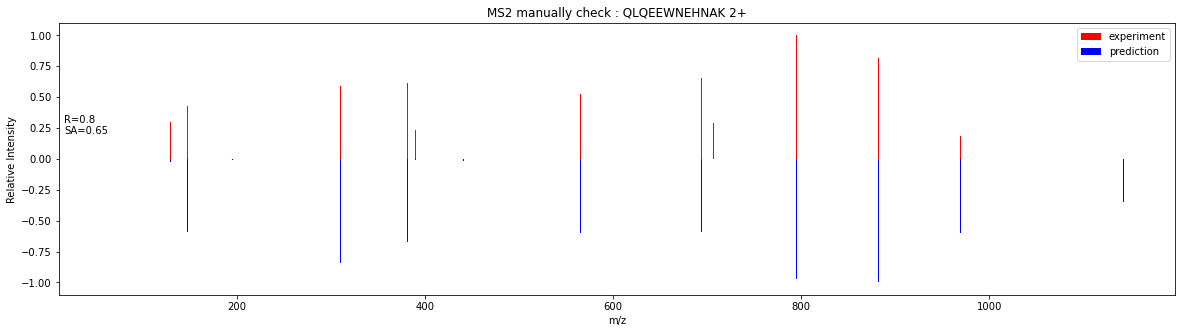

In [149]:
plt.figure(figsize=(20,5))
plt.bar(c_expe.keys(), c_expe.values(), color='red')
plt.bar(c_pred.keys(), list(map(lambda x: -x, c_pred.values())), color='blue')
plt.title('MS2 manually check : QSSSSTELAAYK 2+')
plt.xlabel('m/z')
plt.ylabel('Relative Intensity')
plt.legend(['experiment', 'prediction'])
plt.text(16, 0.2, 
         '\n'.join(['R='+str(vec2r(list(c_expe.values()), list(c_pred.values()))),
                    'SA='+str(vec2sa(list(c_expe.values()), list(c_pred.values())))]))
plt.show()

* QLQEEWNEHNAK 2

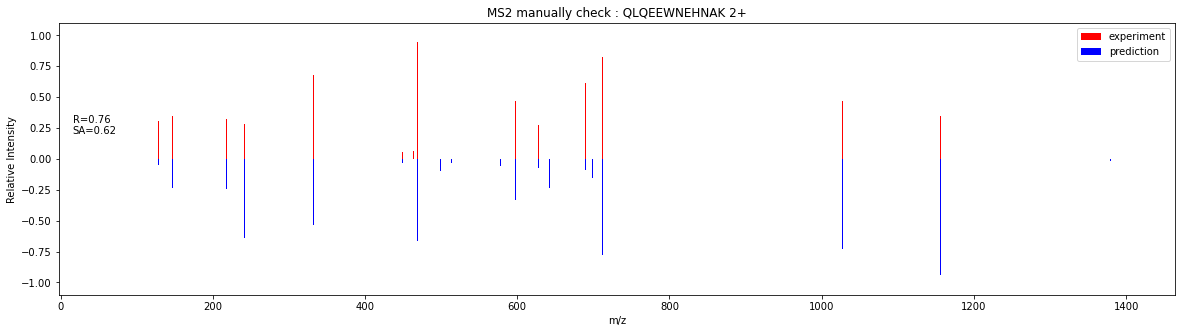

In [150]:
c_pred, c_expe = get_spectrum_fromdf("QLQEEWNEHNAK", 2)

plt.figure(figsize=(20,5))
plt.bar(c_expe.keys(), c_expe.values(), color='red')
plt.bar(c_pred.keys(), list(map(lambda x: -x, c_pred.values())), color='blue')
plt.title('MS2 manually check : QLQEEWNEHNAK 2+')
plt.xlabel('m/z')
plt.ylabel('Relative Intensity')
plt.legend(['experiment', 'prediction'])
plt.text(16, 0.2, 
         '\n'.join(['R='+str(vec2r(list(c_expe.values()), list(c_pred.values()))),
                    'SA='+str(vec2sa(list(c_expe.values()), list(c_pred.values())))]))
plt.show()

* whole evaulation

In [151]:
# peptide to spectrum dictionary (prediction)
tmp = df_ided_pred[['RelativeIntensity', 'FragmentMz',
                   'StrippedPeptide', 'PrecursorCharge']].values
start = time.time()

pep2spec_pred = dict()
for idx, (i, mz, p, c) in enumerate(tmp):
    if idx % 100000 == 0:
        print(idx, round(time.time() - start, 2), end='\r')

    if (p, c) not in pep2spec_pred:
        pep2spec_pred[(p, c)] = dict()
    pep2spec_pred[(p, c)][mz]=i

In [152]:
# peptide to spectrum dictionary (experiment)
tmp = df_ided[['INTENSITY', 'MZ', 
                  'PEPTIDE', 'CHARGE']].values

start = time.time()

pep2spec_expe = dict()
for idx, (i, mz, p, c) in enumerate(tmp):
    if idx % 100000 == 0:
        print(idx, round(time.time() - start, 2), end='\r')

    if (p, c) not in pep2spec_expe:
        pep2spec_expe[(p, c)] = dict()

    for mz_, i_ in zip(list(map(float, mz.split(';'))),
                       list(map(float, i.split(';')))):
        pep2spec_expe[(p, c)][mz_]=i_

In [153]:
def get_spectrum(pep2spec_pred, pep2spec_expe):
    
    # get whole spectrum prediction
    whole_pep2spec_pred = dict()
    
    for pc, mz2int in pep2spec_pred.items():
        c_pred = dict()
        # scaling int scale
        for mz, i in zip(list(mz2int.keys()),
                         list(mz2int.values())):
            if int(mz) not in c_pred:
                c_pred[int(mz)]=[]
            c_pred[int(mz)].append(i)
        for k, v in c_pred.items():
            c_pred[k] = max(v)
            
        whole_pep2spec_pred[pc] = c_pred
        
    # get whole spectrum experiment
    whole_pep2spec_expe = dict()
    
    for pc, mz2int in pep2spec_expe.items():
        c_expe = dict()
        # initialize with prediction spectrum m/z
        for init_k in whole_pep2spec_pred[pc].keys():
            c_expe[init_k] = [0]
        # scaling int scale
        for mz, i in zip(list(mz2int.keys()), 
                        list(mz2int.values())):
            if int(mz) in whole_pep2spec_pred[pc].keys():
                c_expe[int(mz)].append(i)
        for k, v in c_expe.items():
            c_expe[k] = max(v)

        max4norm = max(c_expe.items(), key=lambda x: x[1])[1]
        for k, v in c_expe.items():
            if max4norm != 0:
                c_expe[k] = v / max4norm
            else:
                c_expe[k] = v
        
        whole_pep2spec_expe[pc] = c_expe

    return whole_pep2spec_pred, whole_pep2spec_expe

In [154]:
whole_pep2spec_pred, whole_pep2spec_expe = get_spectrum(pep2spec_pred, pep2spec_expe)

In [197]:
prosit_eval = dict()
for pc, mz2int_pred in whole_pep2spec_pred.items():
    mz2int_expe = whole_pep2spec_expe[pc]
    v1 = list(mz2int_pred.values())
    v2 = list(mz2int_expe.values())
    
    if pc not in prosit_eval:
        prosit_eval[pc] = dict()
    prosit_eval[pc]['R'] = round(vec2r_(v1, v2)[0], 2)
    prosit_eval[pc]['SA'] = vec2sa(v1, v2)

/home/bis/miniconda3/envs/TF2.4/lib/python3.7/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/bis/miniconda3/envs/TF2.4/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


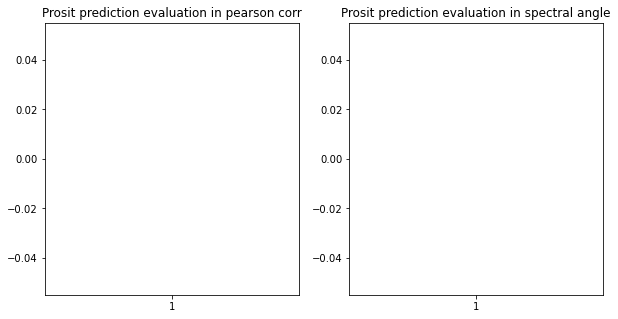

In [198]:
fig, ax = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(10,5)

r_viz = [_['R'] for _ in prosit_eval.values()]
sa_viz = [_['SA'] for _ in prosit_eval.values()]
ax[0].boxplot(r_viz)
ax[1].boxplot(sa_viz)


ax[0].set_title('Prosit prediction evaluation in pearson corr')
ax[1].set_title('Prosit prediction evaluation in spectral angle')

plt.show()  # ? why not working..

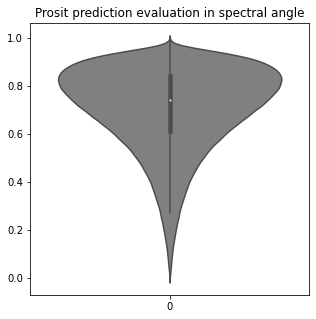

In [199]:
plt.figure(figsize=(5,5))
sns.violinplot(data=sa_viz, color='gray')
plt.title('Prosit prediction evaluation in spectral angle')
plt.show()

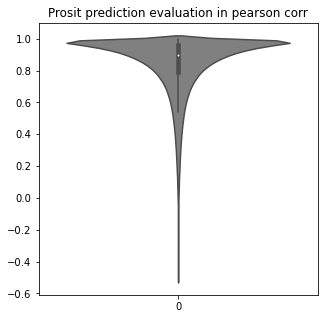

In [200]:
plt.figure(figsize=(5,5))
sns.violinplot(data=r_viz, color='gray')
plt.title('Prosit prediction evaluation in pearson corr')
plt.show()

# MGF DB search result

In [237]:
print(df_ided_pred.shape)
df_ided_pred.head(2)  # precursor charge 1~6이니 2만 있는 nided_pred보다 행이 많은 것. (MS2픽이 더 많은것)

(109641264, 13)


,RelativeIntensity,FragmentMz,ModifiedPeptide,LabeledPeptide,StrippedPeptide,PrecursorCharge,PrecursorMz,iRT,proteotypicity,FragmentNumber,FragmentType,FragmentCharge,FragmentLossType
0,0.035433,134.04478,_AAEAAGGKYRSTVSKSKD_,AAEAAGGKYRSTVSKSKD,AAEAAGGKYRSTVSKSKD,3,609.318273,-26.007053,-9.442945,1,y,1,noloss
1,0.000705,67.52603,_AAEAAGGKYRSTVSKSKD_,AAEAAGGKYRSTVSKSKD,AAEAAGGKYRSTVSKSKD,3,609.318273,-26.007053,-9.442945,1,y,2,noloss


In [238]:
print(df_nided_pred.shape)
df_nided_pred.head(2)

(78003124, 13)


,RelativeIntensity,FragmentMz,ModifiedPeptide,LabeledPeptide,StrippedPeptide,PrecursorCharge,PrecursorMz,iRT,proteotypicity,FragmentNumber,FragmentType,FragmentCharge,FragmentLossType
0,0.18629,175.11896,_SGSGYEGSTSWKAALEDTTTR_,SGSGYEGSTSWKAALEDTTTR,SGSGYEGSTSWKAALEDTTTR,2,1102.508736,66.673958,-5.736105,1,y,1,noloss
1,0.00000,88.06312,_SGSGYEGSTSWKAALEDTTTR_,SGSGYEGSTSWKAALEDTTTR,SGSGYEGSTSWKAALEDTTTR,2,1102.508736,66.673958,-5.736105,1,y,2,noloss


* make mgf 

In [284]:
# Amino acids
MODIFICATION = {
    "CAM": 57.0214637236,  # Carbamidomethylation (CAM)
    "OX": 15.99491,  # Oxidation
}
AMINO_ACID = {
    "G": 57.021464,
    "R": 156.101111,
    "V": 99.068414,
    "P": 97.052764,
    "S": 87.032028,
    "U": 150.95363,
    "L": 113.084064,
    "M": 131.040485,
    "Q": 128.058578,
    "N": 114.042927,
    "Y": 163.063329,
    "E": 129.042593,
    "C": 103.009185,
    "F": 147.068414,
    "I": 113.084064,
    "A": 71.037114,
    "T": 101.047679,
    "W": 186.079313,
    "H": 137.058912,
    "D": 115.026943,
    "K": 128.094963,
}
AMINO_ACID["M(ox)"] = AMINO_ACID["M"] + MODIFICATION["OX"]
AMINO_ACID["C(cam)"] = AMINO_ACID["C"] + MODIFICATION["CAM"]

# Atomic elements
PROTON = 1.007276467
ELECTRON = 0.00054858
H = 1.007825035
C = 12.0
O = 15.99491463
N = 14.003074

# Tiny molecules
N_TERMINUS = H
C_TERMINUS = O + H
CO = C + O
CHO = C + H + O
NH2 = N + H * 2
H2O = H * 2 + O
NH3 = N + H * 3

In [259]:
def cal_MW(seq):
    R = sum([AMINO_ACID[aa] for aa in list(filter(lambda x: ord(x) in range(65, 91), seq))])
    return R + N_TERMINUS + C_TERMINUS

In [264]:
def cal_mz(seq, CHARGE):
    # we treat STRIP_PEPTIDE, so modification does not consider.
    MW = cal_MW(seq)
    return (MW + PROTON*CHARGE) / CHARGE

In [268]:
# peptide to spectrum dictionary (prediction)
tmp = df_nided_pred[['RelativeIntensity', 'FragmentMz',
                   'StrippedPeptide', 'PrecursorCharge']].values
start = time.time()

npep2spec_pred = dict()
for idx, (i, mz, p, c) in enumerate(tmp):
    if idx % 100000 == 0:
        print(idx, round(time.time() - start, 2), end='\r')

    if (p, c) not in npep2spec_pred:
        npep2spec_pred[(p, c)] = dict()
    npep2spec_pred[(p, c)][mz]=i

# pep2spec_pred 는 위에서 이미 구한 값 사용

In [408]:
print('precursor unique count : ', len(npep2spec_pred), len(pep2spec_pred),
      '\nptide sequence unique count : ', len({p[0] for p in npep2spec_pred.keys()}), len({p[0] for p in pep2spec_pred.keys()}))

precursor unique count :  1254637 1457872 
ptide sequence unique count :  1254637 1025874


* save mgf
  - 12 fraction

In [322]:
# ID mgf
start = time.time()

idf01 = open('/data/210827_SJH_prosit/massIVE-KB_predMS2_frac01.mgf', mode='w')
idf02 = open('/data/210827_SJH_prosit/massIVE-KB_predMS2_frac02.mgf', mode='w')
idf03 = open('/data/210827_SJH_prosit/massIVE-KB_predMS2_frac03.mgf', mode='w')
idf04 = open('/data/210827_SJH_prosit/massIVE-KB_predMS2_frac04.mgf', mode='w')
idf05 = open('/data/210827_SJH_prosit/massIVE-KB_predMS2_frac05.mgf', mode='w')
idf06 = open('/data/210827_SJH_prosit/massIVE-KB_predMS2_frac06.mgf', mode='w')
idf07 = open('/data/210827_SJH_prosit/massIVE-KB_predMS2_frac07.mgf', mode='w')
idf08 = open('/data/210827_SJH_prosit/massIVE-KB_predMS2_frac08.mgf', mode='w')
idf09 = open('/data/210827_SJH_prosit/massIVE-KB_predMS2_frac09.mgf', mode='w')
idf10 = open('/data/210827_SJH_prosit/massIVE-KB_predMS2_frac10.mgf', mode='w')
idf11 = open('/data/210827_SJH_prosit/massIVE-KB_predMS2_frac11.mgf', mode='w')
idf12 = open('/data/210827_SJH_prosit/massIVE-KB_predMS2_frac12.mgf', mode='w')
idf2frac = dict()
idf2frac[1]=idf01
idf2frac[2]=idf02
idf2frac[3]=idf03
idf2frac[4]=idf04
idf2frac[5]=idf05
idf2frac[6]=idf06
idf2frac[7]=idf07
idf2frac[8]=idf08
idf2frac[9]=idf09
idf2frac[10]=idf10
idf2frac[11]=idf11
idf2frac[12]=idf12
bins = [int(len(pep2spec_pred)/12 * i) for i in range(12)]
idx2fracidx = np.digitize(range(len(pep2spec_pred)), bins=bins)

for idx, ((p, c), mz2int) in enumerate(pep2spec_pred.items()):
    if idx % 100000 == 0:
        print(idx, round(time.time() - start, 2), end='\r')
    idf = idf2frac[idx2fracidx[idx]]
    idf.write('BEGIN IONS\n')
    idf.write('TITLE='+str(idx+1)+' File:\"massIVE-KB_predMS2.RAW", NativeID:\"controllerType=0 controllerNumber=1 scan='+str(idx+1)+'\"\n')
#     idf.write('RTINSECONDS=10\n')
    idf.write('PEPMASS='+str(cal_mz(p, c))+'\n')  # ' precursor_intensity'
    idf.write('CHARGE='+str(c)+'+\n')
    for mz, i in sorted(mz2int.items(), key=lambda x: x[0]):
        idf.write(str(mz)+' '+str(i)+'\n')
    idf.write('END IONS\n')

In [323]:
idf01.close()
idf02.close()
idf03.close()
idf04.close()
idf05.close()
idf06.close()
idf07.close()
idf08.close()
idf09.close()
idf10.close()
idf11.close()
idf12.close()

In [324]:
# nID mgf
start = time.time()

idf01 = open('/data/210827_SJH_prosit/uniprot_predMS2_frac01.mgf', mode='w')
idf02 = open('/data/210827_SJH_prosit/uniprot_predMS2_frac02.mgf', mode='w')
idf03 = open('/data/210827_SJH_prosit/uniprot_predMS2_frac03.mgf', mode='w')
idf04 = open('/data/210827_SJH_prosit/uniprot_predMS2_frac04.mgf', mode='w')
idf05 = open('/data/210827_SJH_prosit/uniprot_predMS2_frac05.mgf', mode='w')
idf06 = open('/data/210827_SJH_prosit/uniprot_predMS2_frac06.mgf', mode='w')
idf07 = open('/data/210827_SJH_prosit/uniprot_predMS2_frac07.mgf', mode='w')
idf08 = open('/data/210827_SJH_prosit/uniprot_predMS2_frac08.mgf', mode='w')
idf09 = open('/data/210827_SJH_prosit/uniprot_predMS2_frac09.mgf', mode='w')
idf10 = open('/data/210827_SJH_prosit/uniprot_predMS2_frac10.mgf', mode='w')
idf11 = open('/data/210827_SJH_prosit/uniprot_predMS2_frac11.mgf', mode='w')
idf12 = open('/data/210827_SJH_prosit/uniprot_predMS2_frac12.mgf', mode='w')
idf2frac = dict()
idf2frac[1]=idf01
idf2frac[2]=idf02
idf2frac[3]=idf03
idf2frac[4]=idf04
idf2frac[5]=idf05
idf2frac[6]=idf06
idf2frac[7]=idf07
idf2frac[8]=idf08
idf2frac[9]=idf09
idf2frac[10]=idf10
idf2frac[11]=idf11
idf2frac[12]=idf12
bins = [int(len(npep2spec_pred)/12 * i) for i in range(12)]
idx2fracidx = np.digitize(range(len(npep2spec_pred)), bins=bins)

for idx, ((p, c), mz2int) in enumerate(npep2spec_pred.items()):
    if idx % 100000 == 0:
        print(idx, round(time.time() - start, 2), end='\r')
        
    idf = idf2frac[idx2fracidx[idx]]
    idf.write('BEGIN IONS\n')
    idf.write('TITLE='+str(idx+1)+' File:\"uniprot_predMS2.RAW", NativeID:\"controllerType=0 controllerNumber=1 scan='+str(idx+1)+'\"\n')
#     idf.write('RTINSECONDS=10\n')
    idf.write('PEPMASS='+str(cal_mz(p, c))+'\n')  # ' precursor_intensity'
    idf.write('CHARGE='+str(c)+'+\n')
    for mz, i in sorted(mz2int.items(), key=lambda x: x[0]):
        idf.write(str(mz)+' '+str(i)+'\n')
    idf.write('END IONS\n')
idf01.close()
idf02.close()
idf03.close()
idf04.close()
idf05.close()
idf06.close()
idf07.close()
idf08.close()
idf09.close()
idf10.close()
idf11.close()
idf12.close()

* Preceeding MS-GF+ search ...
  - TD FDR 1%
  - DB : uniprot
  - mgf : above mgf (FILENAME, PEPMASS, CHARGE, PEAK_LIST)
* Load Search Result

In [439]:
df_id_result = pd.read_csv('/data/210827_SJH_prosit/search_result/massIVE-KB_result.tsv', sep='\t')
df_nid_result = pd.read_csv('/data/210827_SJH_prosit/search_result/uniprot_result.tsv', sep='\t')

In [440]:
print(df_id_result.shape)
df_id_result.head(1)

(1515056, 17)


,#SpecFile,SpecID,ScanNum,Title,FragMethod,Precursor,IsotopeError,PrecursorError(ppm),Charge,Peptide,Protein,DeNovoScore,MSGFScore,SpecEValue,EValue,QValue,PepQValue
0,massIVE-KB_predMS2_frac01.mgf,index=22130,-1,"22131 File:""massIVE-KB_predMS2.RAW"", NativeID:...",HCD,915.407,0,0.066675,4,NQSQGYNQWQQGQFWGQKPWSQHYHQGYY,"sp|Q00839|HNRPU_HUMAN(pre=K,post=-);tr|A0A1X7S...",264,264,2.147724e-42,5.912638e-35,0.0,0.0


In [441]:
print(df_nid_result.shape)
df_nid_result.head(1)

(1287214, 17)


,#SpecFile,SpecID,ScanNum,Title,FragMethod,Precursor,IsotopeError,PrecursorError(ppm),Charge,Peptide,Protein,DeNovoScore,MSGFScore,SpecEValue,EValue,QValue,PepQValue
0,uniprot_predMS2_frac01.mgf,index=91704,-1,"91705 File:""uniprot_predMS2.RAW"", NativeID:""co...",HCD,1791.814,0,0.0,2,NTFWDVDGSMVPPEWHRWLHSMTDDPPTTK,"sp|Q9UI09|NDUAC_HUMAN(pre=K,post=P)",340,340,3.764748e-42,1.041666e-34,0.0,0.0


* remove PTM peptides

In [446]:
drop_idx = [idx for idx, p in zip(df_id_result.index, df_id_result.Peptide.values) if '+' in p]
print(len(drop_idx))
df_id_result = df_id_result.drop(drop_idx, axis=0).reset_index(drop=True)

239642


In [447]:
drop_idx = [idx for idx, p in zip(df_nid_result.index, df_nid_result.Peptide.values) if '+' in p]
print(len(drop_idx))
df_nid_result = df_nid_result.drop(drop_idx, axis=0).reset_index(drop=True)

178960


* FDR control

In [491]:
def isDecoy(prot):
    prot_cnt = len(prot.split(';'))
    decoy_cnt = 0
    for p in prot.split(';'):
        if 'XXX' in p:
            decoy_cnt += 1
    if decoy_cnt == prot_cnt:
        return 'D'
    else:
        return 'T'

In [544]:
def getFDR(TD_list):
    start = time.time()
    
    FDR_list = []
    T_cnt = 0
    D_cnt = 0
    cut_idx = 0
    
    for idx, label in enumerate(TD_list):
        if label=='T':
            T_cnt += 1
        elif label == 'D':
            D_cnt += 1
        fdr = round((2*D_cnt) / (T_cnt + D_cnt), 2)
        if fdr <= 0.01:
            cut_idx = idx
    return cut_idx

In [545]:
def FDR_control(df, PERCENT):
    df_ = df.sort_values('EValue').reset_index(drop=True)  # copy
    df_['TD_label'] = df_.Protein.apply(isDecoy).values
    print('********** Target Decoy Labelling Done **********')
    cut_idx = getFDR(df_.TD_label.values)  
    print('********** Calculating FDR Done **********')
    df_ = df_.iloc[:cut_idx+1].reset_index(drop=True)
    df_ = df_.loc[df_.TD_label=='T'].reset_index(drop=True)
    return df_

In [549]:
df_id_target = FDR_control(df_id_result, 0.01)

********** Target Decoy Labelling Done **********
********** Calculating FDR Done **********


In [550]:
df_nid_target = FDR_control(df_nid_result, 0.01)

********** Target Decoy Labelling Done **********
********** Calculating FDR Done **********


* decoy protien identificatin count

nonDetection Peptide set : 2346
intersection cnt : 43
Detection Peptide set : 256
whole cnt : 2559



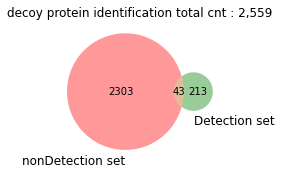

In [584]:
nid_proteins = {__.split('(')[0] for _ in df_nid_target.Protein.values for __ in _.split(';') if 'XXX' in __}
id_proteins = {__.split('(')[0] for _ in df_id_target.Protein.values for __ in _.split(';') if 'XXX' in __}

print('nonDetection Peptide set : {}\n\
intersection cnt : {}\n\
Detection Peptide set : {}\n\
whole cnt : {}\n'.format(len(nid_proteins),
         len(nid_proteins.intersection(id_proteins)),
         len(id_proteins),
         len(nid_proteins.union(id_proteins))))

plt.figure(figsize=(3, 3))
v = venn2(subsets=[nid_proteins, id_proteins], set_labels=('nonDetection set', 'Detection set'))
plt.title('decoy protein identification total cnt : {:,}'.format(len(nid_proteins.union(id_proteins))))
plt.show()

In [585]:
df_id_target_removeDecoy = df_id_target.copy()
df_nid_target_removeDecoy = df_nid_target.copy()

p = []
for prot in df_id_target_removeDecoy.Protein.values:
    p.append(';'.join([_ for _ in prot.split(';') if 'XXX' not in _]))
df_id_target_removeDecoy['Protein'] = p
df_id_target_removeDecoy = df_id_target_removeDecoy.loc[df_id_target_removeDecoy.Protein!='']
p = []
for prot in df_nid_target_removeDecoy.Protein.values:
    p.append(';'.join([_ for _ in prot.split(';') if 'XXX' not in _]))
df_nid_target_removeDecoy['Protein'] = p
df_nid_target_removeDecoy = df_nid_target_removeDecoy.loc[df_nid_target_removeDecoy.Protein!='']

In [586]:
unique_idx = np.where(df_id_target_removeDecoy.Protein.apply(lambda x: ';' not in x))[0]
shared_idx = np.where(df_id_target_removeDecoy.Protein.apply(lambda x: ';' in x))[0]
unique_cnt = len(df_id_target_removeDecoy.loc[unique_idx].Peptide.unique())
shared_cnt = len(df_id_target_removeDecoy.loc[shared_idx].Peptide.unique())
protein_nonMutate = {__.split('(')[0] for _ in df_id_target_removeDecoy.Protein.values for __ in _.split(';')}

print("총 PSM 수 :", len(df_id_target_removeDecoy))
print("펩타이드 수 :", len(df_id_target_removeDecoy.Peptide.unique()))
print('Unique 펩타이드 수 :', unique_cnt)
print('Shared 펩타이드 수 :', shared_cnt)
print('단백질 수 :', len(protein_nonMutate))

unique_idx = np.where(df_nid_target_removeDecoy.Protein.apply(lambda x: ';' not in x))[0]
shared_idx = np.where(df_nid_target_removeDecoy.Protein.apply(lambda x: ';' in x))[0]
unique_cnt = len(df_nid_target_removeDecoy.loc[unique_idx].Peptide.unique())
shared_cnt = len(df_nid_target_removeDecoy.loc[shared_idx].Peptide.unique())
protein_nonMutate = {__.split('(')[0] for _ in df_nid_target_removeDecoy.Protein.values for __ in _.split(';')}

print("총 PSM 수 :", len(df_nid_target_removeDecoy))
print("펩타이드 수 :", len(df_nid_target_removeDecoy.Peptide.unique()))
print('Unique 펩타이드 수 :', unique_cnt)
print('Shared 펩타이드 수 :', shared_cnt)
print('단백질 수 :', len(protein_nonMutate))

총 PSM 수 : 792514
펩타이드 수 : 504495
Unique 펩타이드 수 : 225127
Shared 펩타이드 수 : 279368
단백질 수 : 64900
총 PSM 수 : 905484
펩타이드 수 : 900459
Unique 펩타이드 수 : 424133
Shared 펩타이드 수 : 476326
단백질 수 : 64861


* Protein identification count

In [348]:
from matplotlib_venn import venn2, venn2_circles

In [587]:
nid_proteins = {__.split('(')[0] for _ in df_nid_target.Protein.values for __ in _.split(';') if 'XXX' not in __}
id_proteins = {__.split('(')[0] for _ in df_id_target.Protein.values for __ in _.split(';') if 'XXX' not in __}

print('nonDetection Peptide set : {}\n\
intersection cnt : {}\n\
Detection Peptide set : {}\n\
whole cnt : {}\n'.format(len(nid_proteins),
         len(nid_proteins.intersection(id_proteins)),
         len(id_proteins),
         len(nid_proteins.union(id_proteins))))

nonDetection Peptide set : 64861
intersection cnt : 61605
Detection Peptide set : 64900
whole cnt : 68156



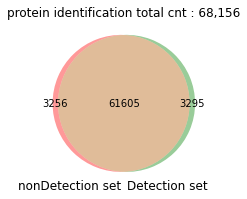

In [588]:
plt.figure(figsize=(3, 3))
v = venn2(subsets=[nid_proteins, id_proteins], set_labels=('nonDetection set', 'Detection set'))
plt.title('protein identification total cnt : {:,}'.format(len(nid_proteins.union(id_proteins))))
plt.show()

* Peptide idenfication count

In [589]:
id_precursors = {(k, v) for k, v in filter(lambda x: '+' not in x[0], df_id_target_removeDecoy[['Peptide', 'Charge']].values)}
nid_precursors = {(k, v) for k, v in filter(lambda x: '+' not in x[0], df_nid_target_removeDecoy[['Peptide', 'Charge']].values)}

print('nonDetection Peptide set : {:,}\n\
intersection cnt : {:,}\n\
Detection Peptide set : {:,}\n\
whole cnt : {:,}\n'.format(len(nid_precursors),
         len(nid_precursors.intersection(id_precursors)),
         len(id_precursors),
         len(nid_precursors.union(id_precursors))))

nonDetection Peptide set : 900,459
intersection cnt : 2,176
Detection Peptide set : 790,737
whole cnt : 1,689,020



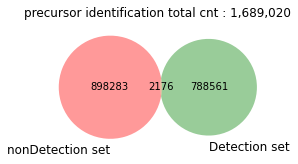

In [590]:
plt.figure(figsize=(4, 4))
v = venn2(subsets=[nid_precursors, id_precursors], set_labels=('nonDetection set', 'Detection set'))
plt.title('precursor identification total cnt : {:,}'.format(len(nid_precursors.union(id_precursors))))
plt.show()

nonDetection Peptide set : 900,459
intersection cnt : 3,686
Detection Peptide set : 504,495
whole cnt : 1,401,268



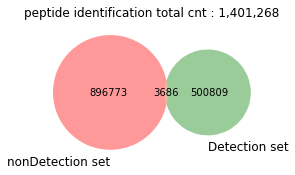

In [591]:
id_peptides = {k for k, v in filter(lambda x: '+' not in x[0], df_id_target_removeDecoy[['Peptide', 'Charge']].values)}
nid_peptides = {k for k, v in filter(lambda x: '+' not in x[0], df_nid_target_removeDecoy[['Peptide', 'Charge']].values)}

print('nonDetection Peptide set : {:,}\n\
intersection cnt : {:,}\n\
Detection Peptide set : {:,}\n\
whole cnt : {:,}\n'.format(len(nid_peptides),
         len(nid_peptides.intersection(id_peptides)),
         len(id_peptides),
         len(nid_peptides.union(id_peptides))))

plt.figure(figsize=(4, 4))
v = venn2(subsets=[nid_peptides, id_peptides], set_labels=('nonDetection set', 'Detection set'))
plt.title('peptide identification total cnt : {:,}'.format(len(nid_peptides.union(id_peptides))))
plt.show()

* MSGFscore violin plot

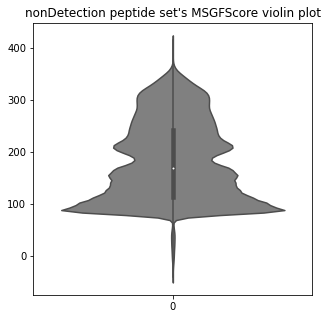

In [592]:
plt.figure(figsize=(5,5))
sns.violinplot(data=df_nid_target_removeDecoy.MSGFScore.values, color='gray')
plt.title('nonDetection peptide set\'s MSGFScore violin plot')
plt.show()

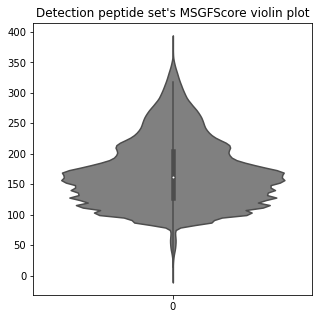

In [593]:
plt.figure(figsize=(5,5))
sns.violinplot(data=df_id_target_removeDecoy.MSGFScore.values, color='gray')
plt.title('Detection peptide set\'s MSGFScore violin plot')
plt.show()

In [594]:
df_nonid = pd.DataFrame([[_, 'nonID', 'score'] for _ in df_nid_target_removeDecoy.MSGFScore.values],
                        columns=['MSGFScore', 'label', 'score'])
df_id = pd.DataFrame([[_, 'ID', 'score'] for _ in df_id_target_removeDecoy.MSGFScore.values],
                     columns=['MSGFScore', 'label', 'score'])

df_MSGFScore = pd.concat([df_nonid, df_id], axis=0).reset_index(drop=True)

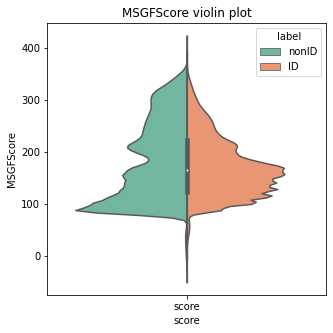

In [595]:
plt.figure(figsize=(5,5))
sns.violinplot(x='score', y="MSGFScore", hue="label",
                    data=df_MSGFScore, 
                    palette="Set2",
                    split=True,
                    scale="count"
                   )
plt.title('MSGFScore violin plot')
plt.show()

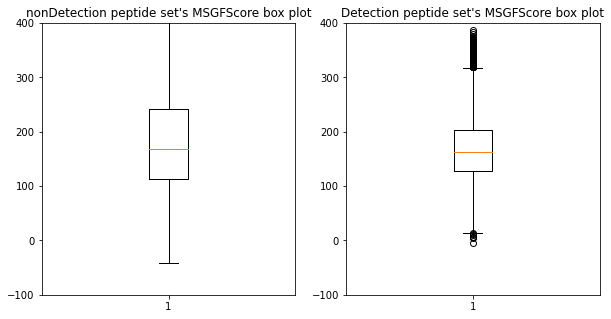

In [596]:
fig, ax = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(10,5)
ax[0].boxplot(df_nid_target_removeDecoy.MSGFScore.values)
ax[1].boxplot(df_id_target_removeDecoy.MSGFScore.values)

ax[0].set_ylim(-100, 400)
ax[1].set_ylim(-100, 400)
ax[0].set_title('nonDetection peptide set\'s MSGFScore box plot')
ax[1].set_title('Detection peptide set\'s MSGFScore box plot')

plt.show()